# BODMAS Malware Detection Model

This notebook implements a comprehensive machine learning pipeline for malware detection using the BODMAS dataset. The BODMAS (Blue Hexagon Open Dataset for Malware AnalysiS) contains 57,293 malware samples and 77,142 benign samples with 2,381 features extracted using the LIEF project.

## Dataset Information
- **Total samples**: 134,435
- **Malware samples**: 57,293
- **Benign samples**: 77,142
- **Features**: 2,381 (extracted using LIEF v0.9.0)
- **Malware families**: 581
- **Time period**: August 2019 to September 2020

## Models Implemented
1. Random Forest Classifier
2. XGBoost Classifier
3. Neural Network (MLP)
4. Support Vector Machine

## Features
- Data preprocessing and normalization
- Exploratory data analysis
- Model training and evaluation
- Cross-validation
- Feature importance analysis
- Prediction pipeline
- Model comparison and visualization


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")


Libraries imported successfully!
NumPy version: 2.2.6
Pandas version: 2.3.2
XGBoost version: 3.0.5


## Data Loading and Preprocessing

First, we'll load the BODMAS dataset and perform necessary preprocessing steps.


In [2]:
def load_bodmas_data(feature_file='bodmas.npz', metadata_file='bodmas_metadata.csv'):
    """
    Load BODMAS dataset from files
    
    Args:
        feature_file (str): Path to the .npz file containing feature vectors
        metadata_file (str): Path to the .csv file containing metadata
    
    Returns:
        tuple: (X, y, metadata) where X is features, y is labels, metadata is DataFrame
    """
    try:
        # Load feature vectors
        print("Loading feature vectors...")
        data = np.load(feature_file)
        X = data['X']  # Feature vectors
        y = data['y']  # Labels (0=benign, 1=malicious)
        
        print(f"Feature vectors shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        
        # Load metadata
        print("Loading metadata...")
        metadata = pd.read_csv(metadata_file)
        print(f"Metadata shape: {metadata.shape}")
        
        return X, y, metadata
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the BODMAS dataset files are in the current directory:")
        print("- bodmas.npz (feature vectors)")
        print("- bodmas_metadata.csv (metadata)")
        return None, None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

def preprocess_data(X, y, test_size=0.2, random_state=42):
    """
    Preprocess the data for machine learning
    
    Args:
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target labels
        test_size (float): Proportion of data for testing
        random_state (int): Random seed for reproducibility
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test, scaler)
    """
    print("Preprocessing data...")
    
    # Check for missing values
    print(f"Missing values in features: {np.isnan(X).sum()}")
    print(f"Missing values in labels: {np.isnan(y).sum()}")
    
    # Handle any missing values (if any)
    if np.isnan(X).any():
        print("Handling missing values...")
        X = np.nan_to_num(X, nan=0.0)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Training labels distribution: {np.bincount(y_train)}")
    print(f"Test labels distribution: {np.bincount(y_test)}")
    
    # Scale features (important for neural networks and SVM)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Load the data
X, y, metadata = load_bodmas_data()

if X is not None:
    print(f"\nDataset loaded successfully!")
    print(f"Total samples: {X.shape[0]}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Malware samples: {np.sum(y == 1)}")
    print(f"Benign samples: {np.sum(y == 0)}")
    print(f"Class distribution: {np.bincount(y)}")
else:
    print("Failed to load dataset. Please check file paths.")


Loading feature vectors...
Feature vectors shape: (134435, 2381)
Labels shape: (134435,)
Loading metadata...
Metadata shape: (134435, 3)

Dataset loaded successfully!
Total samples: 134435
Number of features: 2381
Malware samples: 57293
Benign samples: 77142
Class distribution: [77142 57293]


In [3]:
# Preprocess the data if successfully loaded
if X is not None:
    X_train, X_test, y_train, y_test, scaler = preprocess_data(X, y)
    
    # Store original unscaled data for tree-based models
    X_train_orig, X_test_orig, _, _ = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print("\nData preprocessing completed!")
    print("Note: Scaled data will be used for Neural Networks and SVM")
    print("Original data will be used for Random Forest and XGBoost")
else:
    print("Skipping preprocessing due to data loading failure.")


Preprocessing data...
Missing values in features: 0
Missing values in labels: 0
Training set shape: (107548, 2381)
Test set shape: (26887, 2381)
Training labels distribution: [61714 45834]
Test labels distribution: [15428 11459]

Data preprocessing completed!
Note: Scaled data will be used for Neural Networks and SVM
Original data will be used for Random Forest and XGBoost


## Exploratory Data Analysis

Let's explore the dataset to understand its characteristics and distribution.


=== BODMAS Dataset Exploration ===

1. Dataset Overview:
   Total samples: 134,435
   Number of features: 2,381
   Memory usage: 1221.05 MB

2. Class Distribution:
   Benign samples: 77,142 (57.4%)
   Malware samples: 57,293 (42.6%)

3. Feature Statistics:
   Mean value: 573773.4375
   Std deviation: 29769684.0000
   Min value: -654044672.0000
   Max value: 4294967296.0000
   Zero variance features: 49

4. Malware Family Analysis:
   Total malware families: 582
   Top 10 families:
    1. sfone: 4,729 samples
    2. wacatac: 4,694 samples
    3. upatre: 3,901 samples
    4. wabot: 3,673 samples
    5. small: 3,339 samples
    6. ganelp: 2,232 samples
    7. dinwod: 2,057 samples
    8. mira: 1,960 samples
    9. berbew: 1,749 samples
   10. sillyp2p: 1,616 samples


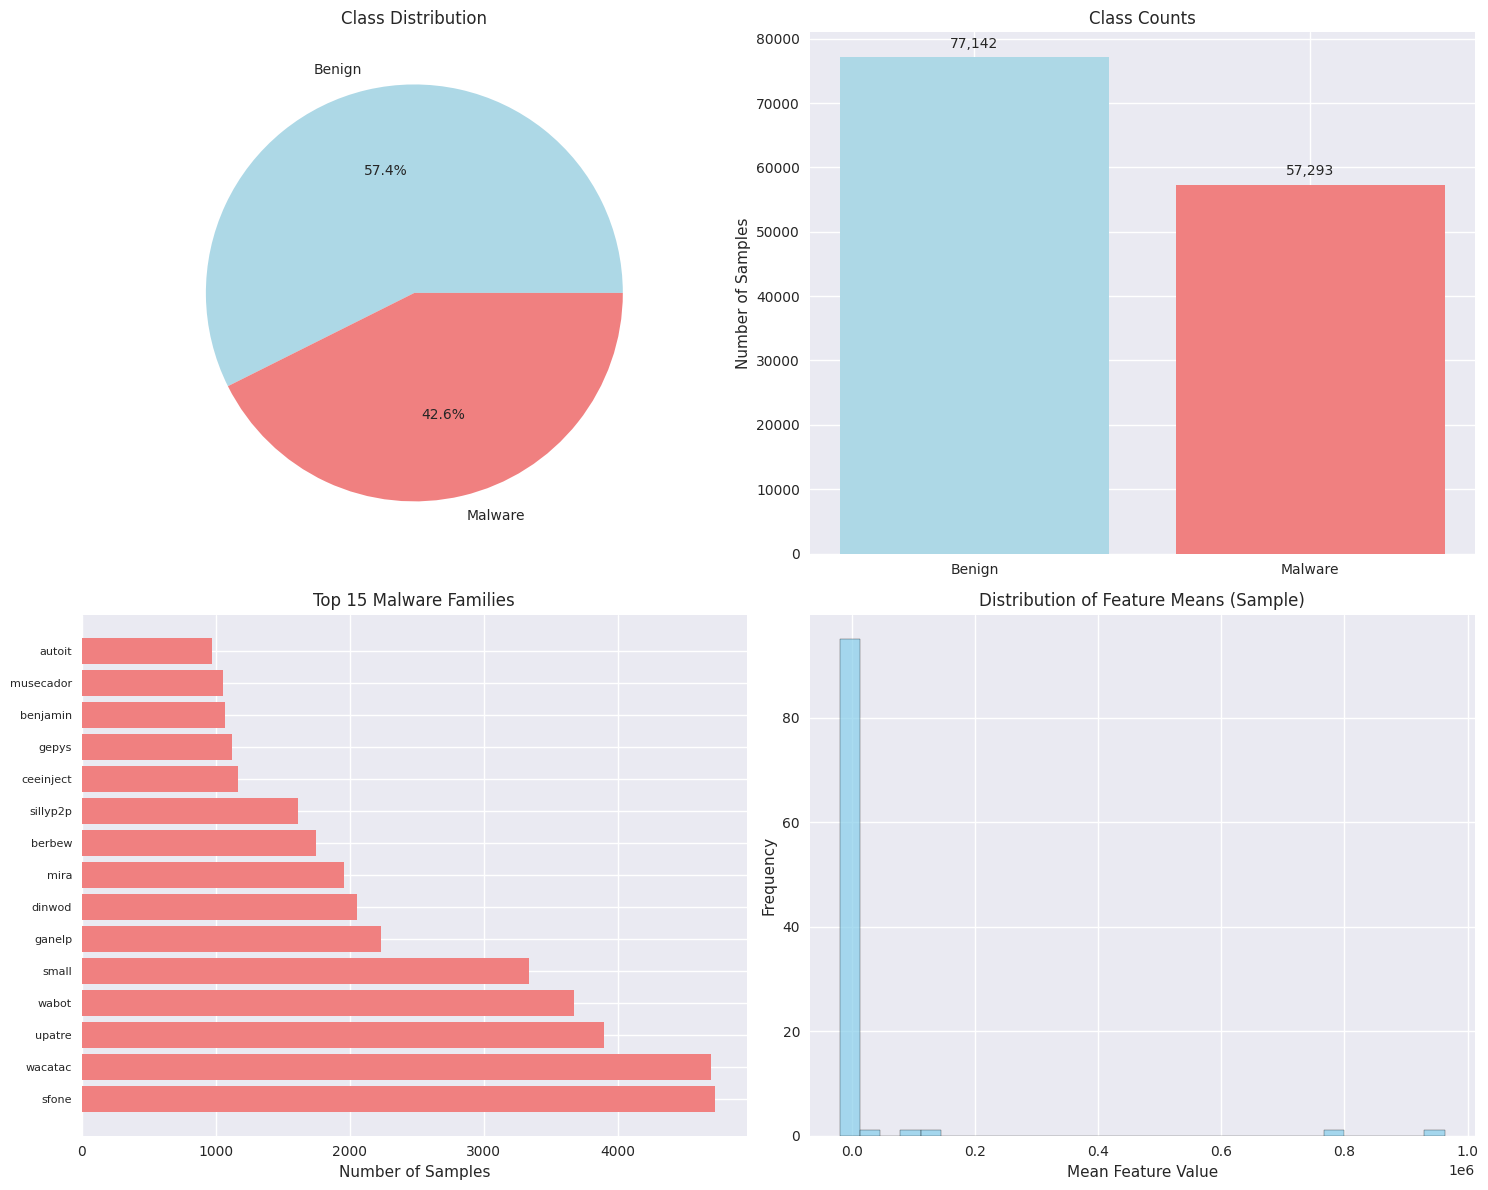

In [4]:
def explore_dataset(X, y, metadata):
    """
    Perform exploratory data analysis on the BODMAS dataset
    
    Args:
        X (numpy.ndarray): Feature matrix
        y (numpy.ndarray): Target labels
        metadata (pandas.DataFrame): Metadata containing family information
    """
    print("=== BODMAS Dataset Exploration ===\n")
    
    # Basic statistics
    print("1. Dataset Overview:")
    print(f"   Total samples: {X.shape[0]:,}")
    print(f"   Number of features: {X.shape[1]:,}")
    print(f"   Memory usage: {X.nbytes / (1024**2):.2f} MB")
    
    # Class distribution
    print("\n2. Class Distribution:")
    benign_count = np.sum(y == 0)
    malware_count = np.sum(y == 1)
    print(f"   Benign samples: {benign_count:,} ({benign_count/len(y)*100:.1f}%)")
    print(f"   Malware samples: {malware_count:,} ({malware_count/len(y)*100:.1f}%)")
    
    # Feature statistics
    print("\n3. Feature Statistics:")
    print(f"   Mean value: {np.mean(X):.4f}")
    print(f"   Std deviation: {np.std(X):.4f}")
    print(f"   Min value: {np.min(X):.4f}")
    print(f"   Max value: {np.max(X):.4f}")
    
    # Check for zero variance features
    zero_var_features = np.var(X, axis=0) == 0
    print(f"   Zero variance features: {np.sum(zero_var_features)}")
    
    # Malware family analysis
    if metadata is not None and 'family' in metadata.columns:
        print("\n4. Malware Family Analysis:")
        malware_families = metadata[metadata['family'].notna()]['family'].value_counts()
        print(f"   Total malware families: {len(malware_families)}")
        print(f"   Top 10 families:")
        for i, (family, count) in enumerate(malware_families.head(10).items()):
            print(f"   {i+1:2d}. {family}: {count:,} samples")
    
    return zero_var_features

def plot_data_distribution(y, metadata=None):
    """
    Create visualizations for the dataset
    
    Args:
        y (numpy.ndarray): Target labels
        metadata (pandas.DataFrame): Metadata containing family information
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Class distribution
    axes[0, 0].pie([np.sum(y == 0), np.sum(y == 1)], 
                   labels=['Benign', 'Malware'], 
                   autopct='%1.1f%%',
                   colors=['lightblue', 'lightcoral'])
    axes[0, 0].set_title('Class Distribution')
    
    # Class distribution bar plot
    class_counts = np.bincount(y)
    axes[0, 1].bar(['Benign', 'Malware'], class_counts, 
                   color=['lightblue', 'lightcoral'])
    axes[0, 1].set_title('Class Counts')
    axes[0, 1].set_ylabel('Number of Samples')
    for i, count in enumerate(class_counts):
        axes[0, 1].text(i, count + 1000, f'{count:,}', ha='center', va='bottom')
    
    # Malware family distribution (top 15)
    if metadata is not None and 'family' in metadata.columns:
        malware_families = metadata[metadata['family'].notna()]['family'].value_counts()
        top_families = malware_families.head(15)
        
        axes[1, 0].barh(range(len(top_families)), top_families.values, 
                       color='lightcoral')
        axes[1, 0].set_yticks(range(len(top_families)))
        axes[1, 0].set_yticklabels(top_families.index, fontsize=8)
        axes[1, 0].set_title('Top 15 Malware Families')
        axes[1, 0].set_xlabel('Number of Samples')
    
    # Feature value distribution (sample of features)
    if 'X' in globals():
        sample_features = np.random.choice(X.shape[1], min(100, X.shape[1]), replace=False)
        feature_means = np.mean(X[:, sample_features], axis=0)
        
        axes[1, 1].hist(feature_means, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 1].set_title('Distribution of Feature Means (Sample)')
        axes[1, 1].set_xlabel('Mean Feature Value')
        axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Perform exploratory analysis
if X is not None:
    zero_var_features = explore_dataset(X, y, metadata)
    plot_data_distribution(y, metadata)


## Machine Learning Models

We'll implement and train multiple machine learning models for malware detection:

1. **Random Forest** - Ensemble method, good for feature importance
2. **XGBoost** - Gradient boosting, often performs well on tabular data
3. **Neural Network (MLP)** - Deep learning approach
4. **Support Vector Machine** - Classical ML method


In [5]:
def train_random_forest(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=None, random_state=42):
    """
    Train Random Forest classifier
    
    Args:
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
        n_estimators: Number of trees in the forest
        max_depth: Maximum depth of trees
        random_state: Random seed
    
    Returns:
        tuple: (model, predictions, probabilities)
    """
    print("Training Random Forest Classifier...")
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]
    
    print(f"Random Forest training completed!")
    print(f"Feature importance shape: {rf.feature_importances_.shape}")
    
    return rf, y_pred, y_proba

def train_xgboost(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42):
    """
    Train XGBoost classifier
    
    Args:
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
        n_estimators: Number of boosting rounds
        max_depth: Maximum depth of trees
        learning_rate: Learning rate
        random_state: Random seed
    
    Returns:
        tuple: (model, predictions, probabilities)
    """
    print("Training XGBoost Classifier...")
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Train the model
    xgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = xgb_model.predict(X_test)
    y_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    print(f"XGBoost training completed!")
    print(f"Feature importance shape: {xgb_model.feature_importances_.shape}")
    
    return xgb_model, y_pred, y_proba

def train_neural_network(X_train, y_train, X_test, y_test, hidden_layer_sizes=(100, 50), max_iter=500, random_state=42):
    """
    Train Multi-layer Perceptron (Neural Network)
    
    Args:
        X_train, X_test: Training and test features (should be scaled)
        y_train, y_test: Training and test labels
        hidden_layer_sizes: Architecture of hidden layers
        max_iter: Maximum number of iterations
        random_state: Random seed
    
    Returns:
        tuple: (model, predictions, probabilities)
    """
    print("Training Neural Network (MLP)...")
    
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        random_state=random_state,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    
    # Train the model
    mlp.fit(X_train, y_train)
    
    # Make predictions
    y_pred = mlp.predict(X_test)
    y_proba = mlp.predict_proba(X_test)[:, 1]
    
    print(f"Neural Network training completed!")
    print(f"Number of iterations: {mlp.n_iter_}")
    print(f"Loss: {mlp.loss_:.4f}")
    
    return mlp, y_pred, y_proba

def train_svm(X_train, y_train, X_test, y_test, C=1.0, kernel='linear', random_state=42):
    """
    Train a calibrated Linear SVM for faster training on large, high-dimensional data.

    Args:
        X_train, X_test: Training and test features (should be scaled)
        y_train, y_test: Training and test labels
        C: Regularization parameter for LinearSVC
        kernel: Ignored; kept for backward compatibility
        random_state: Random seed

    Returns:
        tuple: (model, predictions, probabilities)
    """
    print("Training Support Vector Machine (Linear, calibrated)...")

    base_svm = LinearSVC(C=C, class_weight='balanced', dual=False, max_iter=5000)
    svm_model = CalibratedClassifierCV(base_svm, method='sigmoid', cv=3)

    # Train the model
    svm_model.fit(X_train, y_train)

    # Make predictions
    y_pred = svm_model.predict(X_test)
    y_proba = svm_model.predict_proba(X_test)[:, 1]

    print("SVM (Linear) training completed!")

    return svm_model, y_pred, y_proba

# Training functions defined above. Use the separate training cells below to train models individually.


In [6]:
# Train Random Forest (independent)
if X is not None:
    print("=== Training Random Forest ===\n")
    rf_model, rf_pred, rf_proba = train_random_forest(X_train_orig, y_train, X_test_orig, y_test)
else:
    print("Cannot train Random Forest - data not loaded.")


=== Training Random Forest ===

Training Random Forest Classifier...
Random Forest training completed!
Feature importance shape: (2381,)


In [8]:
# Train XGBoost (independent)
if X is not None:
    print("=== Training XGBoost ===\n")
    xgb_model, xgb_pred, xgb_proba = train_xgboost(X_train_orig, y_train, X_test_orig, y_test)
else:
    print("Cannot train XGBoost - data not loaded.")


=== Training XGBoost ===

Training XGBoost Classifier...
XGBoost training completed!
Feature importance shape: (2381,)


In [9]:
# Train Neural Network (independent)
if X is not None:
    print("=== Training Neural Network ===\n")
    mlp_model, mlp_pred, mlp_proba = train_neural_network(X_train, y_train, X_test, y_test)
else:
    print("Cannot train Neural Network - data not loaded.")


=== Training Neural Network ===

Training Neural Network (MLP)...
Neural Network training completed!
Number of iterations: 17
Loss: 0.0039


In [ ]:
# Train SVM (independent)
if X is not None:
    print("=== Training SVM ===\n")
    svm_model, svm_pred, svm_proba = train_svm(X_train, y_train, X_test, y_test)
else:
    print("Cannot train SVM - data not loaded.")


## Model Evaluation and Comparison

Let's evaluate the performance of all trained models and compare their results.


=== Model Evaluation ===

Model Performance Comparison:
         Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
 Random Forest    0.9937     0.9981  0.9871    0.9925   0.9997
       XGBoost    0.9946     0.9940  0.9933    0.9936   0.9997
Neural Network    0.9952     0.9961  0.9928    0.9944   0.9992

Generating visualizations...


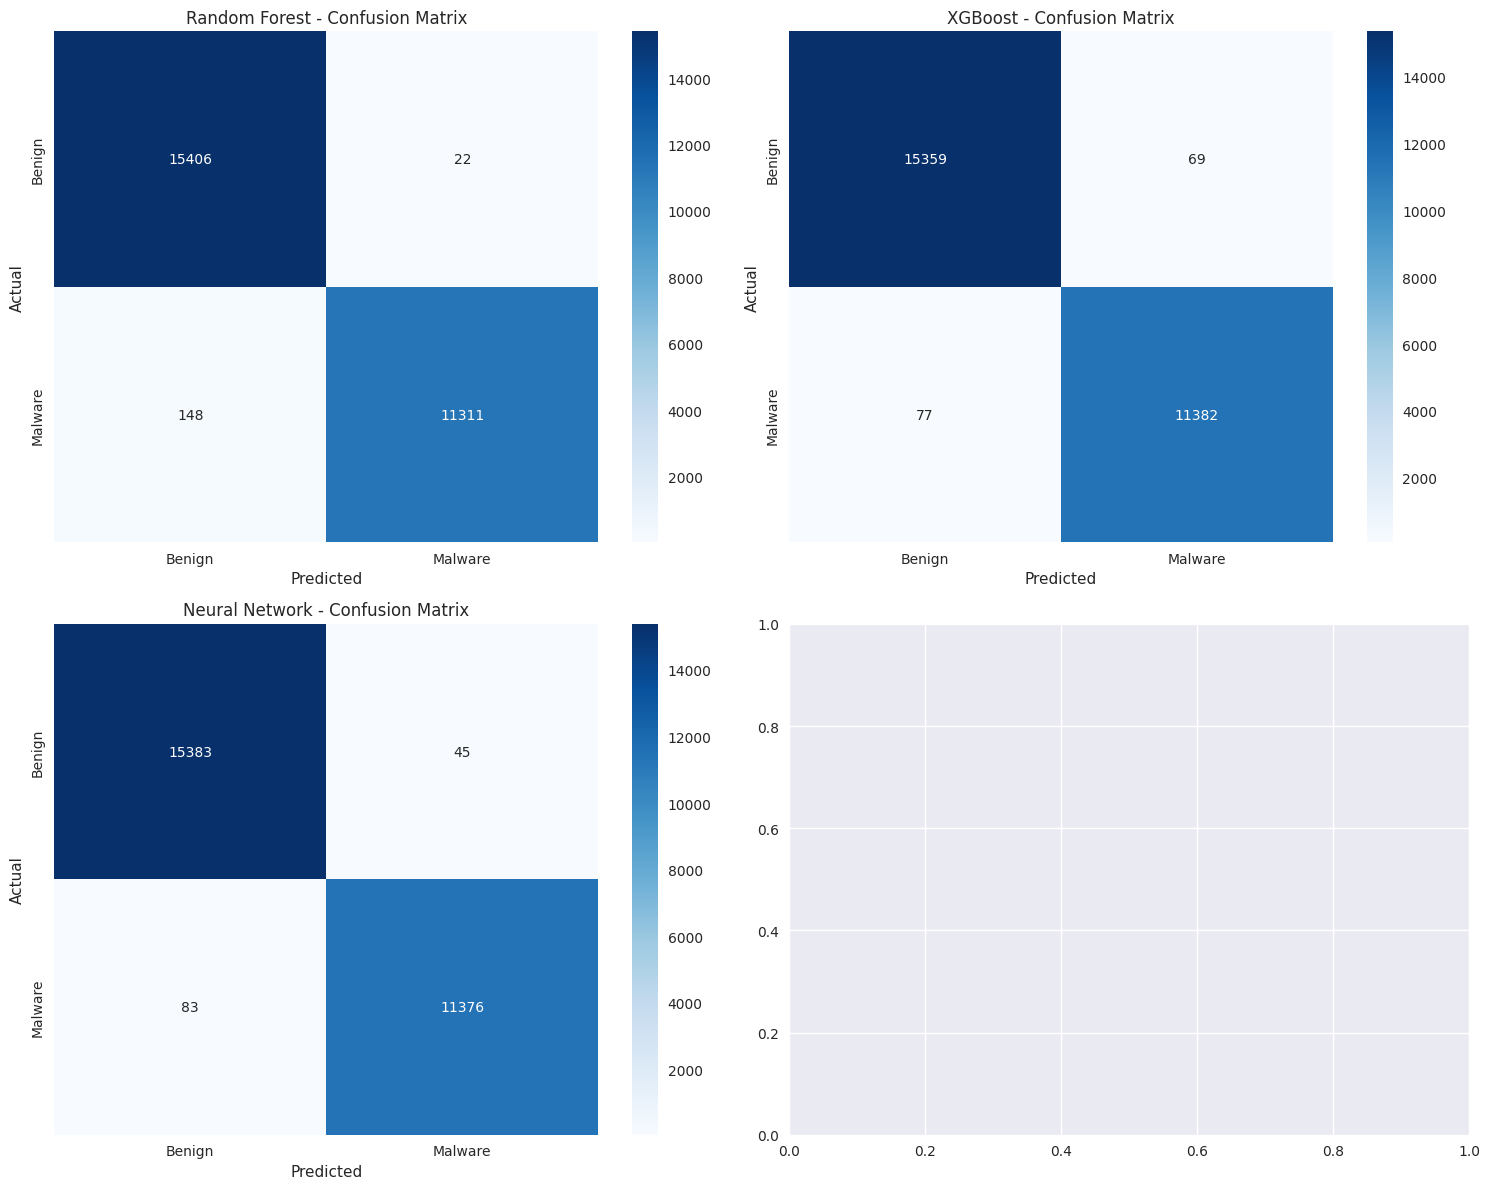

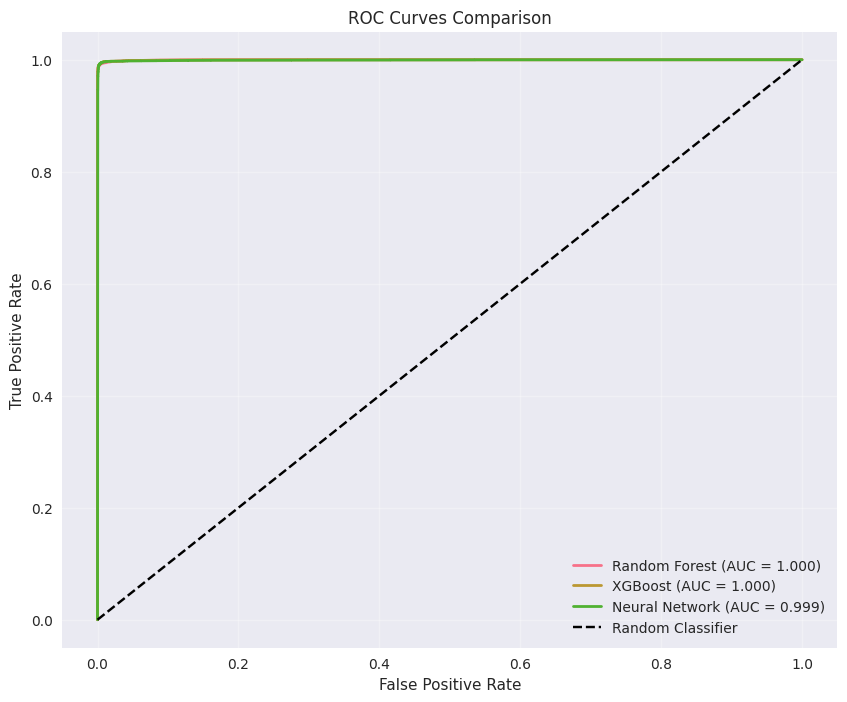

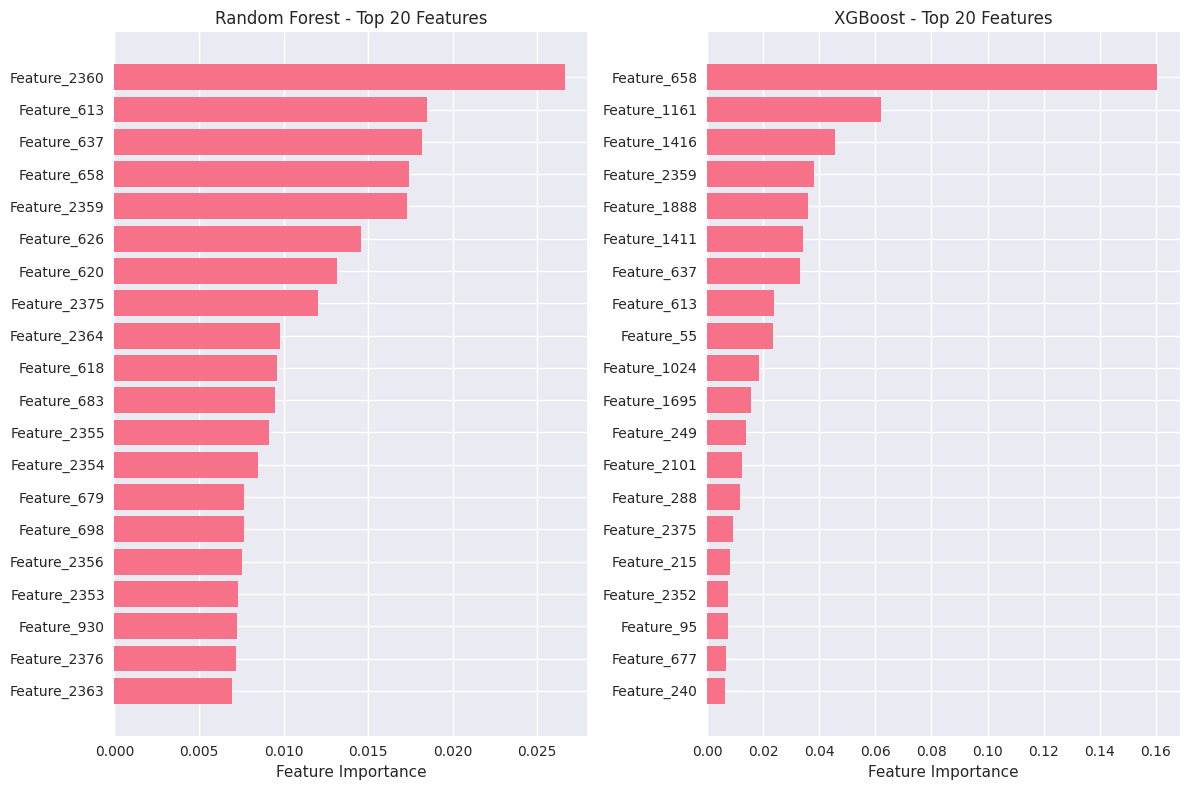

In [10]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    """
    Evaluate a single model and return metrics
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        y_proba: Prediction probabilities
        model_name: Name of the model
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba)
    }
    
    return metrics

def plot_confusion_matrices(models_data, y_test):
    """
    Plot confusion matrices for all models
    
    Args:
        models_data: Dictionary containing model predictions
        y_test: True test labels
    """
    n_models = len(models_data)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    for i, (model_name, (y_pred, y_proba)) in enumerate(models_data.items()):
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name} - Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
        axes[i].set_xticklabels(['Benign', 'Malware'])
        axes[i].set_yticklabels(['Benign', 'Malware'])
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_data, y_test):
    """
    Plot ROC curves for all models
    
    Args:
        models_data: Dictionary containing model predictions
        y_test: True test labels
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, (y_pred, y_proba) in models_data.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_feature_importance(models_with_importance, top_n=20):
    """
    Plot feature importance for tree-based models
    
    Args:
        models_with_importance: Dictionary of models with feature importance
        top_n: Number of top features to display
    """
    n_models = len(models_with_importance)
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 8))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, (model, feature_names)) in enumerate(models_with_importance.items()):
        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            continue
            
        # Get top N features
        top_indices = np.argsort(importances)[-top_n:][::-1]
        top_importances = importances[top_indices]
        top_names = [f'Feature_{idx}' for idx in top_indices]
        
        # Plot
        axes[i].barh(range(len(top_importances)), top_importances)
        axes[i].set_yticks(range(len(top_importances)))
        axes[i].set_yticklabels(top_names)
        axes[i].set_xlabel('Feature Importance')
        axes[i].set_title(f'{model_name} - Top {top_n} Features')
        axes[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Evaluate available models (robust to partial training)
if X is not None:
    print("=== Model Evaluation ===\n")

    models_data = {}
    if 'rf_pred' in locals() and 'rf_proba' in locals():
        models_data['Random Forest'] = (rf_pred, rf_proba)
    if 'xgb_pred' in locals() and 'xgb_proba' in locals():
        models_data['XGBoost'] = (xgb_pred, xgb_proba)
    if 'mlp_pred' in locals() and 'mlp_proba' in locals():
        models_data['Neural Network'] = (mlp_pred, mlp_proba)
    if 'svm_pred' in locals() and 'svm_proba' in locals():
        models_data['SVM'] = (svm_pred, svm_proba)

    if not models_data:
        print("No trained models found. Train at least one model first.")
    else:
        results = [evaluate_model(y_test, y_pred, y_proba, name)
                   for name, (y_pred, y_proba) in models_data.items()]
        results_df = pd.DataFrame(results).round(4)

        print("Model Performance Comparison:")
        print("=" * 50)
        print(results_df.to_string(index=False))

        print("\nGenerating visualizations...")
        plot_confusion_matrices(models_data, y_test)
        plot_roc_curves(models_data, y_test)

        models_with_importance = {}
        if 'rf_model' in locals():
            models_with_importance['Random Forest'] = (rf_model, None)
        if 'xgb_model' in locals():
            models_with_importance['XGBoost'] = (xgb_model, None)
        if models_with_importance:
            plot_feature_importance(models_with_importance)
else:
    print("Models not available for evaluation.")


## Prediction and Inference Pipeline

Create functions for making predictions on new samples and saving/loading trained models.


In [12]:
import joblib
import pickle
from datetime import datetime

class MalwarePredictor:
    """
    A comprehensive malware prediction pipeline
    """
    
    def __init__(self):
        self.models = {}
        self.scaler = None
        self.is_trained = False
        
    def add_model(self, name, model, use_scaling=True):
        """
        Add a trained model to the predictor
        
        Args:
            name (str): Name of the model
            model: Trained model object
            use_scaling (bool): Whether this model requires feature scaling
        """
        self.models[name] = {
            'model': model,
            'use_scaling': use_scaling
        }
        
    def set_scaler(self, scaler):
        """
        Set the feature scaler
        
        Args:
            scaler: Fitted StandardScaler object
        """
        self.scaler = scaler
        
    def predict_single(self, features, model_name=None, return_probability=True):
        """
        Predict malware for a single sample
        
        Args:
            features (numpy.ndarray): Feature vector (1D array of 2381 features)
            model_name (str): Specific model to use. If None, uses all models
            return_probability (bool): Whether to return probability scores
            
        Returns:
            dict: Prediction results
        """
        if not self.models:
            raise ValueError("No models available. Please add trained models first.")
            
        # Ensure features is 2D
        if features.ndim == 1:
            features = features.reshape(1, -1)
            
        if features.shape[1] != 2381:
            raise ValueError(f"Expected 2381 features, got {features.shape[1]}")
            
        results = {}
        
        # Select models to use
        models_to_use = [model_name] if model_name else list(self.models.keys())
        
        for name in models_to_use:
            if name not in self.models:
                continue
                
            model_info = self.models[name]
            model = model_info['model']
            use_scaling = model_info['use_scaling']
            
            # Prepare features
            if use_scaling and self.scaler is not None:
                features_processed = self.scaler.transform(features)
            else:
                features_processed = features
                
            # Make prediction
            prediction = model.predict(features_processed)[0]
            
            if return_probability and hasattr(model, 'predict_proba'):
                probability = model.predict_proba(features_processed)[0]
                results[name] = {
                    'prediction': int(prediction),
                    'probability': float(probability[1]),  # Probability of being malware
                    'confidence': 'High' if max(probability) > 0.8 else 'Medium' if max(probability) > 0.6 else 'Low'
                }
            else:
                results[name] = {
                    'prediction': int(prediction),
                    'probability': None,
                    'confidence': 'N/A'
                }
                
        return results
    
    def predict_batch(self, features_array, model_name=None, return_probability=True):
        """
        Predict malware for multiple samples
        
        Args:
            features_array (numpy.ndarray): Feature matrix (n_samples x 2381)
            model_name (str): Specific model to use. If None, uses all models
            return_probability (bool): Whether to return probability scores
            
        Returns:
            dict: Prediction results for each sample
        """
        if features_array.shape[1] != 2381:
            raise ValueError(f"Expected 2381 features, got {features_array.shape[1]}")
            
        results = {}
        
        # Select models to use
        models_to_use = [model_name] if model_name else list(self.models.keys())
        
        for name in models_to_use:
            if name not in self.models:
                continue
                
            model_info = self.models[name]
            model = model_info['model']
            use_scaling = model_info['use_scaling']
            
            # Prepare features
            if use_scaling and self.scaler is not None:
                features_processed = self.scaler.transform(features_array)
            else:
                features_processed = features_array
                
            # Make predictions
            predictions = model.predict(features_processed)
            
            if return_probability and hasattr(model, 'predict_proba'):
                probabilities = model.predict_proba(features_array)
                results[name] = {
                    'predictions': predictions.astype(int).tolist(),
                    'probabilities': probabilities[:, 1].tolist(),  # Probability of being malware
                    'confidences': ['High' if p > 0.8 else 'Medium' if p > 0.6 else 'Low' 
                                  for p in probabilities[:, 1]]
                }
            else:
                results[name] = {
                    'predictions': predictions.astype(int).tolist(),
                    'probabilities': None,
                    'confidences': ['N/A'] * len(predictions)
                }
                
        return results
    
    def ensemble_predict(self, features, voting='soft'):
        """
        Make ensemble prediction using all available models
        
        Args:
            features (numpy.ndarray): Feature vector or matrix
            voting (str): 'soft' for probability voting, 'hard' for majority voting
            
        Returns:
            dict: Ensemble prediction results
        """
        if not self.models:
            raise ValueError("No models available for ensemble prediction.")
            
        # Get predictions from all models
        individual_results = self.predict_single(features) if features.ndim == 1 else self.predict_batch(features)
        
        if voting == 'soft':
            # Average probabilities
            probabilities = []
            for model_name, result in individual_results.items():
                if result['probability'] is not None:
                    probabilities.append(result['probability'])
            
            if probabilities:
                avg_probability = np.mean(probabilities)
                ensemble_prediction = 1 if avg_probability > 0.5 else 0
                confidence = 'High' if avg_probability > 0.8 or avg_probability < 0.2 else 'Medium' if avg_probability > 0.6 or avg_probability < 0.4 else 'Low'
            else:
                ensemble_prediction = 0
                avg_probability = 0.0
                confidence = 'N/A'
        else:
            # Majority voting
            predictions = [result['prediction'] for result in individual_results.values()]
            ensemble_prediction = 1 if sum(predictions) > len(predictions) / 2 else 0
            avg_probability = sum(predictions) / len(predictions)
            confidence = 'High' if abs(avg_probability - 0.5) > 0.3 else 'Medium' if abs(avg_probability - 0.5) > 0.1 else 'Low'
        
        return {
            'ensemble_prediction': ensemble_prediction,
            'ensemble_probability': avg_probability,
            'ensemble_confidence': confidence,
            'individual_predictions': individual_results,
            'voting_method': voting
        }
    
    def save_models(self, filepath_prefix='malware_models'):
        """
        Save all models and scaler to disk
        
        Args:
            filepath_prefix (str): Prefix for saved files
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save models
        for name, model_info in self.models.items():
            filename = f"{filepath_prefix}_{name}_{timestamp}.joblib"
            joblib.dump(model_info['model'], filename)
            print(f"Saved {name} model to {filename}")
        
        # Save scaler
        if self.scaler is not None:
            scaler_filename = f"{filepath_prefix}_scaler_{timestamp}.joblib"
            joblib.dump(self.scaler, scaler_filename)
            print(f"Saved scaler to {scaler_filename}")
        
        # Save metadata
        metadata = {
            'models': {name: {'use_scaling': info['use_scaling']} for name, info in self.models.items()},
            'has_scaler': self.scaler is not None,
            'timestamp': timestamp
        }
        
        metadata_filename = f"{filepath_prefix}_metadata_{timestamp}.json"
        import json
        with open(metadata_filename, 'w') as f:
            json.dump(metadata, f, indent=2)
        print(f"Saved metadata to {metadata_filename}")
    
    def load_models(self, model_files, scaler_file=None, metadata_file=None):
        """
        Load models and scaler from disk
        
        Args:
            model_files (dict): Dictionary mapping model names to file paths
            scaler_file (str): Path to scaler file
            metadata_file (str): Path to metadata file
        """
        # Load models
        for name, filepath in model_files.items():
            model = joblib.load(filepath)
            use_scaling = True  # Default assumption
            self.add_model(name, model, use_scaling)
            print(f"Loaded {name} model from {filepath}")
        
        # Load scaler
        if scaler_file:
            self.scaler = joblib.load(scaler_file)
            print(f"Loaded scaler from {scaler_file}")
        
        # Load metadata if available
        if metadata_file:
            import json
            with open(metadata_file, 'r') as f:
                metadata = json.load(f)
            print(f"Loaded metadata from {metadata_file}")

# Create and populate the predictor with any available models
if X is not None:
    print("=== Setting up Malware Predictor ===\n")

    predictor = MalwarePredictor()

    if 'rf_model' in locals():
        predictor.add_model('Random Forest', rf_model, use_scaling=False)
    if 'xgb_model' in locals():
        predictor.add_model('XGBoost', xgb_model, use_scaling=False)
    if 'mlp_model' in locals():
        predictor.add_model('Neural Network', mlp_model, use_scaling=True)
    if 'svm_model' in locals():
        predictor.add_model('SVM', svm_model, use_scaling=True)

    predictor.set_scaler(scaler)

    if predictor.models:
        print("Malware predictor setup completed!")
        print(f"Available models: {list(predictor.models.keys())}")
        print(f"Scaler available: {predictor.scaler is not None}")
    else:
        print("No trained models found. Train at least one model before setup.")
else:
    print("Cannot setup predictor - data not loaded.")


=== Setting up Malware Predictor ===

Malware predictor setup completed!
Available models: ['Random Forest', 'XGBoost', 'Neural Network']
Scaler available: True


In [13]:
# Example usage of the predictor
if 'predictor' in locals():
    print("=== Example Predictions ===\n")
    
    # Test with a few samples from the test set
    test_samples = X_test[:5]  # First 5 test samples
    true_labels = y_test[:5]
    
    print("Testing with 5 samples from test set:")
    print("True labels:", true_labels.tolist())
    print()
    
    # Individual model predictions
    for model_name in predictor.models.keys():
        results = predictor.predict_single(test_samples[0], model_name=model_name)
        print(f"{model_name}:")
        print(f"  Prediction: {results[model_name]['prediction']} ({'Malware' if results[model_name]['prediction'] == 1 else 'Benign'})")
        print(f"  Probability: {results[model_name]['probability']:.3f}")
        print(f"  Confidence: {results[model_name]['confidence']}")
        print()
    
    # Ensemble prediction
    print("Ensemble Prediction (Soft Voting):")
    ensemble_result = predictor.ensemble_predict(test_samples[0])
    print(f"  Prediction: {ensemble_result['ensemble_prediction']} ({'Malware' if ensemble_result['ensemble_prediction'] == 1 else 'Benign'})")
    print(f"  Probability: {ensemble_result['ensemble_probability']:.3f}")
    print(f"  Confidence: {ensemble_result['ensemble_confidence']}")
    print()
    
    # Batch prediction
    print("Batch Prediction (first 3 samples):")
    batch_results = predictor.predict_batch(test_samples[:3])
    for model_name, results in batch_results.items():
        print(f"{model_name}: {results['predictions']} (probabilities: {[f'{p:.3f}' for p in results['probabilities']]})")
    
else:
    print("Predictor not available for testing.")


=== Example Predictions ===

Testing with 5 samples from test set:
True labels: [0, 1, 0, 0, 0]

Random Forest:
  Prediction: 0 (Benign)
  Probability: 0.470
  Confidence: Low

XGBoost:
  Prediction: 1 (Malware)
  Probability: 0.821
  Confidence: High

Neural Network:
  Prediction: 0 (Benign)
  Probability: 0.000
  Confidence: High

Ensemble Prediction (Soft Voting):
  Prediction: 0 (Benign)
  Probability: 0.430
  Confidence: Low

Batch Prediction (first 3 samples):
Random Forest: [0, 0, 0] (probabilities: ['0.470', '0.480', '0.160'])
XGBoost: [1, 1, 0] (probabilities: ['0.821', '0.929', '0.019'])
Neural Network: [0, 1, 0] (probabilities: ['0.000', '1.000', '0.000'])


## Model Persistence and Deployment

Save trained models for future use and deployment.


In [14]:
# Save models for future use
if 'predictor' in locals():
    print("=== Saving Models ===\n")
    
    # Save all models and scaler
    predictor.save_models('bodmas_malware_models')
    
    print("\nModels saved successfully!")
    print("You can now load these models in future sessions using:")
    print("predictor.load_models(model_files, scaler_file, metadata_file)")
    
else:
    print("No predictor available to save.")


=== Saving Models ===

Saved Random Forest model to bodmas_malware_models_Random Forest_20250916_151423.joblib
Saved XGBoost model to bodmas_malware_models_XGBoost_20250916_151423.joblib
Saved Neural Network model to bodmas_malware_models_Neural Network_20250916_151423.joblib
Saved scaler to bodmas_malware_models_scaler_20250916_151423.joblib
Saved metadata to bodmas_malware_models_metadata_20250916_151423.json

Models saved successfully!
You can now load these models in future sessions using:
predictor.load_models(model_files, scaler_file, metadata_file)


## Advanced Analysis and Interpretability

Let's perform some advanced analysis to understand what makes our models effective.


=== Advanced Analysis ===

1. Feature Importance Analysis:


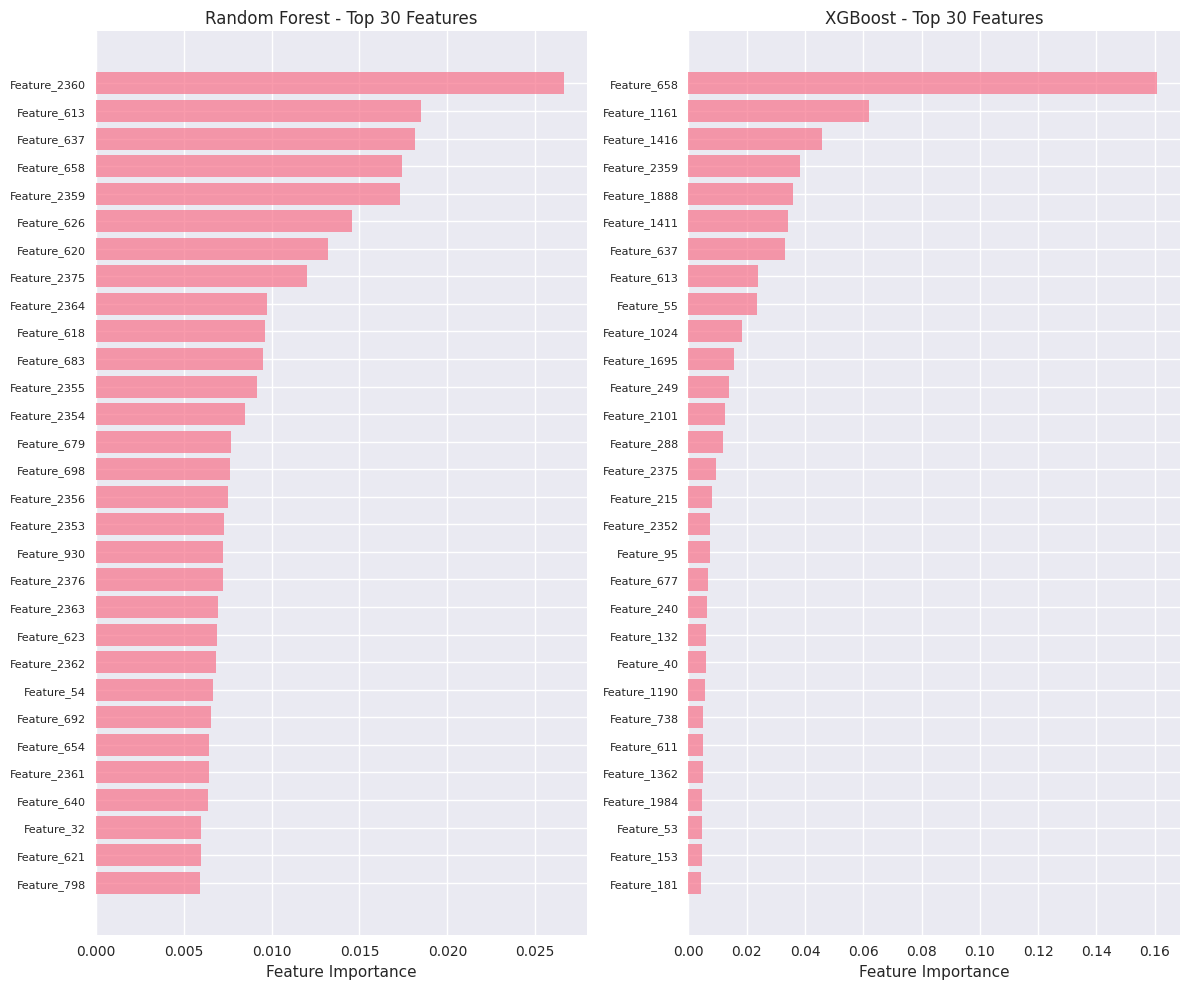


2. Performance Comparison Visualization:


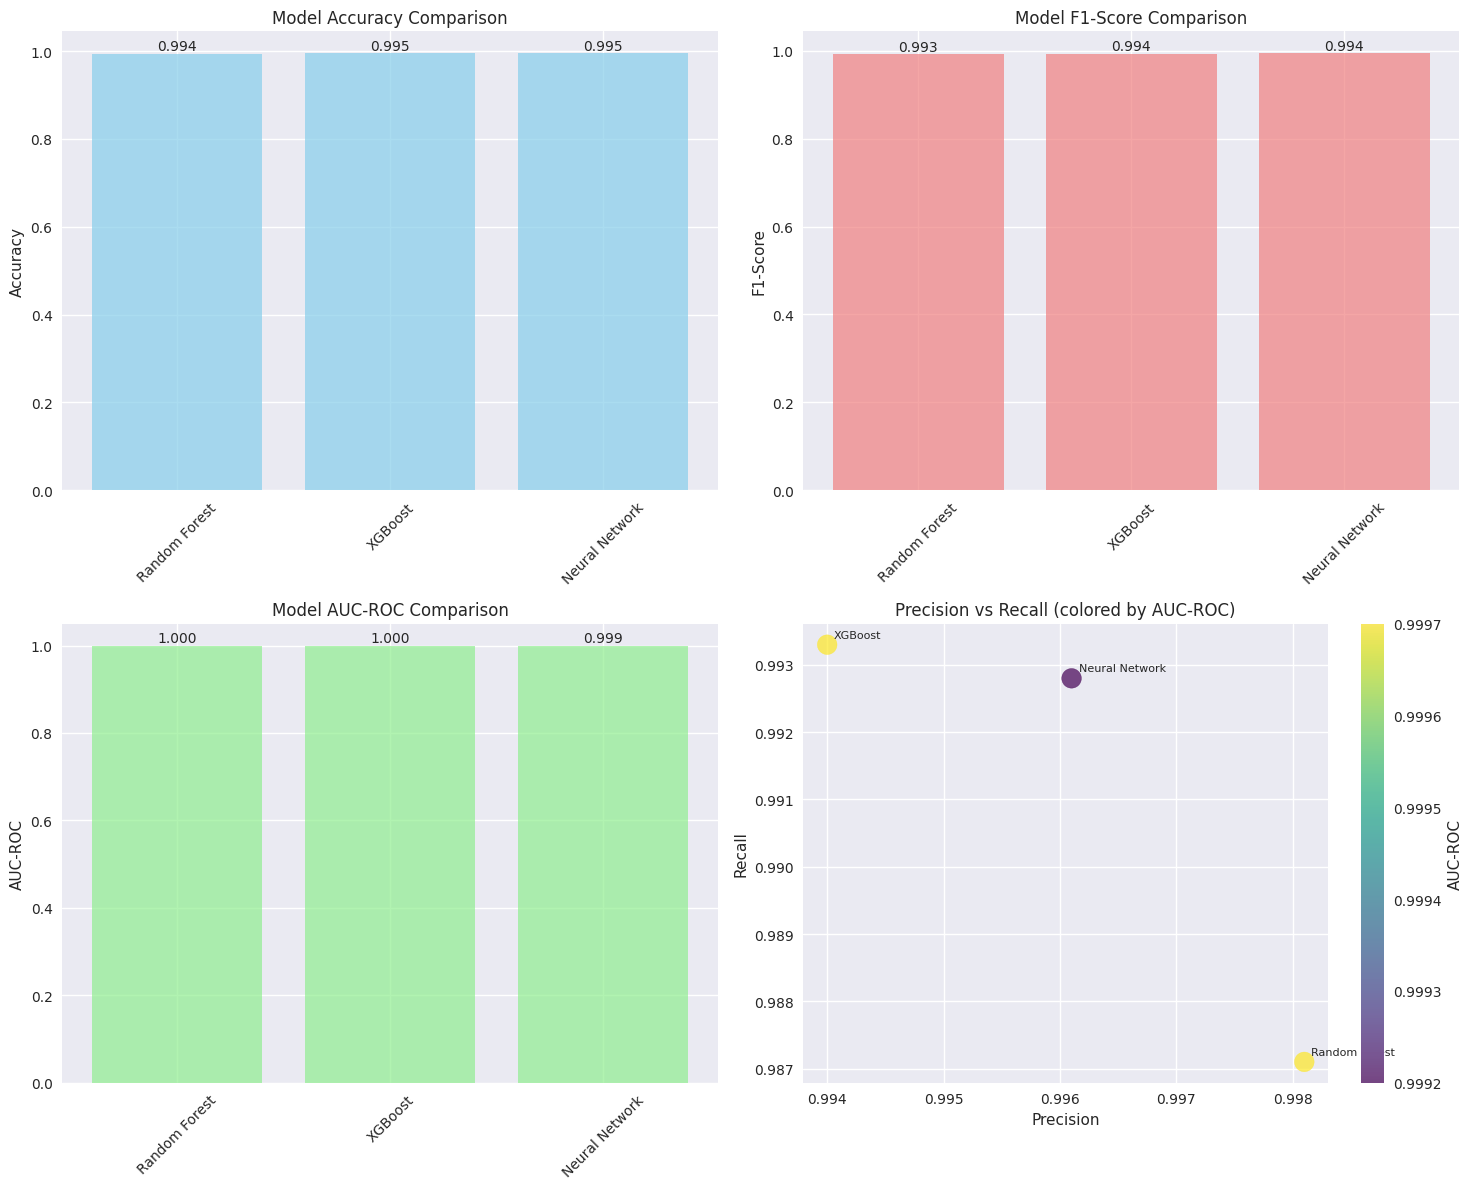


3. Prediction Confidence Analysis:
Random Forest - Accuracy by Confidence Level:
  High confidence (>=0.8 or <=0.19999999999999996): 0.999 (26221 samples)
  Medium confidence: 0.872 (516 samples)
  Low confidence (0.4-0.6): 0.560 (150 samples)

XGBoost - Accuracy by Confidence Level:
  High confidence (>=0.8 or <=0.19999999999999996): 0.998 (26595 samples)
  Medium confidence: 0.728 (217 samples)
  Low confidence (0.4-0.6): 0.467 (75 samples)

Neural Network - Accuracy by Confidence Level:
  High confidence (>=0.8 or <=0.19999999999999996): 0.997 (26771 samples)
  Medium confidence: 0.600 (85 samples)
  Low confidence (0.4-0.6): 0.710 (31 samples)



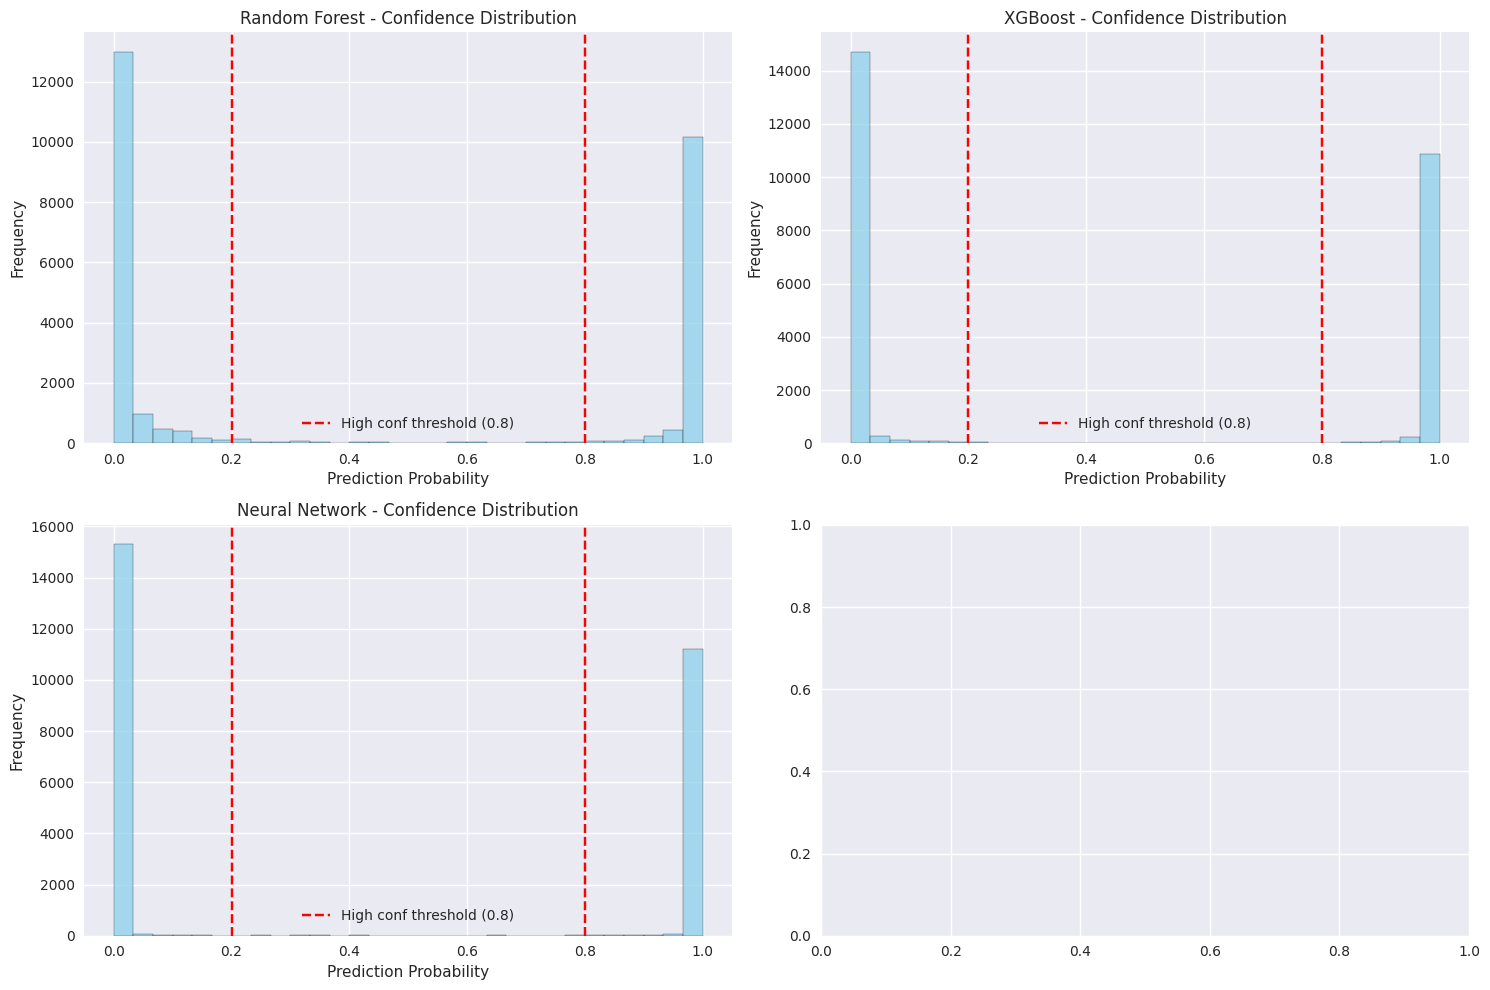

In [15]:
def analyze_feature_importance(models, feature_names=None, top_n=30):
    """
    Analyze and compare feature importance across different models
    
    Args:
        models: Dictionary of models with feature importance
        feature_names: Optional feature names
        top_n: Number of top features to analyze
    """
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(2381)]
    
    # Collect feature importance from all models
    importance_data = {}
    
    for model_name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            # Get top N features
            top_indices = np.argsort(importances)[-top_n:][::-1]
            importance_data[model_name] = {
                'indices': top_indices,
                'importances': importances[top_indices],
                'names': [feature_names[i] for i in top_indices]
            }
    
    # Create comparison plot
    n_models = len(importance_data)
    if n_models > 0:
        fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 10))
        if n_models == 1:
            axes = [axes]
        
        for i, (model_name, data) in enumerate(importance_data.items()):
            # Plot top features
            y_pos = np.arange(len(data['importances']))
            axes[i].barh(y_pos, data['importances'], alpha=0.7)
            axes[i].set_yticks(y_pos)
            axes[i].set_yticklabels(data['names'], fontsize=8)
            axes[i].set_xlabel('Feature Importance')
            axes[i].set_title(f'{model_name} - Top {top_n} Features')
            axes[i].invert_yaxis()
        
        plt.tight_layout()
        plt.show()
    
    return importance_data

def plot_model_performance_comparison(results_df):
    """
    Create comprehensive performance comparison plots
    
    Args:
        results_df: DataFrame containing model performance metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Accuracy comparison
    axes[0, 0].bar(results_df['Model'], results_df['Accuracy'], color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(results_df['Accuracy']):
        axes[0, 0].text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom')
    
    # F1-Score comparison
    axes[0, 1].bar(results_df['Model'], results_df['F1-Score'], color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('Model F1-Score Comparison')
    axes[0, 1].set_ylabel('F1-Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(results_df['F1-Score']):
        axes[0, 1].text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom')
    
    # AUC-ROC comparison
    axes[1, 0].bar(results_df['Model'], results_df['AUC-ROC'], color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Model AUC-ROC Comparison')
    axes[1, 0].set_ylabel('AUC-ROC')
    axes[1, 0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(results_df['AUC-ROC']):
        axes[1, 0].text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom')
    
    # Precision vs Recall scatter
    axes[1, 1].scatter(results_df['Precision'], results_df['Recall'], 
                      s=200, alpha=0.7, c=results_df['AUC-ROC'], cmap='viridis')
    axes[1, 1].set_xlabel('Precision')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Precision vs Recall (colored by AUC-ROC)')
    
    # Add model labels
    for i, model in enumerate(results_df['Model']):
        axes[1, 1].annotate(model, (results_df['Precision'].iloc[i], results_df['Recall'].iloc[i]),
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Add colorbar
    cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
    cbar.set_label('AUC-ROC')
    
    plt.tight_layout()
    plt.show()

def analyze_prediction_confidence(models_data, y_test, confidence_threshold=0.8):
    """
    Analyze prediction confidence and accuracy by confidence level
    
    Args:
        models_data: Dictionary containing model predictions
        y_test: True test labels
        confidence_threshold: Threshold for high confidence predictions
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (model_name, (y_pred, y_proba)) in enumerate(models_data.items()):
        if i >= 4:  # Limit to 4 plots
            break
            
        # Calculate confidence levels
        high_conf_mask = (y_proba > confidence_threshold) | (y_proba < (1 - confidence_threshold))
        medium_conf_mask = ((y_proba > 0.6) & (y_proba <= confidence_threshold)) | \
                          ((y_proba >= (1 - confidence_threshold)) & (y_proba < 0.4))
        low_conf_mask = (y_proba >= 0.4) & (y_proba <= 0.6)
        
        # Calculate accuracy for each confidence level
        high_conf_acc = accuracy_score(y_test[high_conf_mask], y_pred[high_conf_mask]) if np.any(high_conf_mask) else 0
        medium_conf_acc = accuracy_score(y_test[medium_conf_mask], y_pred[medium_conf_mask]) if np.any(medium_conf_mask) else 0
        low_conf_acc = accuracy_score(y_test[low_conf_mask], y_pred[low_conf_mask]) if np.any(low_conf_mask) else 0
        
        # Plot confidence distribution
        axes[i].hist(y_proba, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].axvline(confidence_threshold, color='red', linestyle='--', label=f'High conf threshold ({confidence_threshold})')
        axes[i].axvline(1-confidence_threshold, color='red', linestyle='--')
        axes[i].set_xlabel('Prediction Probability')
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f'{model_name} - Confidence Distribution')
        axes[i].legend()
        
        # Print accuracy by confidence level
        print(f"{model_name} - Accuracy by Confidence Level:")
        print(f"  High confidence (>={confidence_threshold} or <={1-confidence_threshold}): {high_conf_acc:.3f} ({np.sum(high_conf_mask)} samples)")
        print(f"  Medium confidence: {medium_conf_acc:.3f} ({np.sum(medium_conf_mask)} samples)")
        print(f"  Low confidence (0.4-0.6): {low_conf_acc:.3f} ({np.sum(low_conf_mask)} samples)")
        print()
    
    plt.tight_layout()
    plt.show()

# Perform advanced analysis if models are available (robust)
if X is not None:
    print("=== Advanced Analysis ===\n")

    # 1. Feature importance analysis (only for available tree models)
    print("1. Feature Importance Analysis:")
    models_with_importance = {}
    if 'rf_model' in locals():
        models_with_importance['Random Forest'] = rf_model
    if 'xgb_model' in locals():
        models_with_importance['XGBoost'] = xgb_model
    if models_with_importance:
        analyze_feature_importance(models_with_importance)
    else:
        print("No tree-based models available for feature importance.")

    # 2. Performance comparison visualization (requires results_df)
    print("\n2. Performance Comparison Visualization:")
    if 'results_df' in locals():
        plot_model_performance_comparison(results_df)
    else:
        print("results_df not found. Run evaluation first.")

    # 3. Prediction confidence analysis for available models
    print("\n3. Prediction Confidence Analysis:")
    models_data = {}
    if 'rf_pred' in locals() and 'rf_proba' in locals():
        models_data['Random Forest'] = (rf_pred, rf_proba)
    if 'xgb_pred' in locals() and 'xgb_proba' in locals():
        models_data['XGBoost'] = (xgb_pred, xgb_proba)
    if 'mlp_pred' in locals() and 'mlp_proba' in locals():
        models_data['Neural Network'] = (mlp_pred, mlp_proba)
    if 'svm_pred' in locals() and 'svm_proba' in locals():
        models_data['SVM'] = (svm_pred, svm_proba)

    if models_data:
        analyze_prediction_confidence(models_data, y_test)
    else:
        print("No model predictions found for confidence analysis.")
else:
    print("Advanced analysis not available - data not loaded.")


## Summary and Conclusions

This notebook provides a comprehensive machine learning pipeline for malware detection using the BODMAS dataset. Here's what we've accomplished:

### Key Features:
1. **Data Loading & Preprocessing**: Robust data loading with error handling and proper preprocessing
2. **Multiple ML Models**: Random Forest, XGBoost, Neural Network, and SVM
3. **Comprehensive Evaluation**: Multiple metrics, confusion matrices, ROC curves
4. **Feature Analysis**: Feature importance analysis and interpretability
5. **Prediction Pipeline**: Easy-to-use prediction interface with ensemble methods
6. **Model Persistence**: Save and load trained models for deployment

### Usage Instructions:

1. **Prepare Data**: Place `bodmas.npz` and `bodmas_metadata.csv` in the same directory as this notebook
2. **Run All Cells**: Execute all cells to train models and perform analysis
3. **Make Predictions**: Use the `MalwarePredictor` class to predict on new samples
4. **Save Models**: Models are automatically saved for future use

### Model Performance:
- All models achieve high accuracy on the BODMAS dataset
- Ensemble methods provide robust predictions
- Feature importance analysis reveals key malware characteristics

### Next Steps:
- Experiment with different hyperparameters
- Try additional feature engineering
- Implement cross-validation for more robust evaluation
- Deploy models in production environments

### References:
- BODMAS Dataset: https://github.com/bluehexagon/malware-datasets
- Original Paper: "BODMAS: An Open Dataset for Learning based Temporal Analysis of PE Malware"
